# Toxic Comment Classification – Code Summary

## 1. Data Loading and Overview
- Load and inspect training, test, and submission files.
- Check for missing values and class distribution.

## 2. Exploratory Data Analysis (EDA)
- Analyze label frequencies and multilabel distributions.
- Compare word counts across labels.
- Visualize text using WordClouds, boxplots, and TF-IDF statistics.

## 3. Data Preprocessing
- Clean text: remove URLs, punctuation, emojis, and slurs.
- Tokenize, remove stopwords, and apply stemming.
- Limit to 150 tokens and save cleaned data.

## 4. Feature Extraction – TF-IDF
- Apply `TfidfVectorizer` with unigrams and bigrams.
- Transform and save both training and test sets.
- Export the fitted vectorizer.

## 5. Model Training and Evaluation – TF-IDF
- Train **Logistic Regression**, **Linear SVM**, and **Naive Bayes**.
- Evaluate using Accuracy, F1-score, Precision, Recall, and AUC.
- Visualize per-class performance and model comparison.
- Save all trained models.

## 6. Feature Extraction – Word Embeddings
- Use `spaCy` (`en_core_web_md`) to compute sentence-level embeddings.
- Standardize features and save train/validation sets.

## 7. Model Training and Evaluation – Embeddings
- Train **Logistic Regression**, **Linear SVM**, and **Gaussian Naive Bayes**.
- Evaluate models and plot F1-score comparisons.
- Save best-performing model and metrics.

## 8. Hyperparameter Tuning – Logistic Regression (TF-IDF)
- Use `RandomizedSearchCV` to optimize Logistic Regression.
- Track tuning time, best hyperparameters, and final metrics.
- Plot performance and generate confusion matrices.
- Save the tuned model.

## 9. Final Prediction and Submission
- Apply TF-IDF transformation to cleaned test set.
- Use the tuned Logistic Regression model for predictions.
- Create and export the Kaggle submission file.


In [1]:
# Chapter 1 – Data Loading and Overview

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style for plots
sns.set(style="whitegrid")
%matplotlib inline

# Load main datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")
sample_submission = pd.read_csv("sample_submission.csv")

# Preview the first few rows of the training set
print("Sample comments from the training dataset:")
display(train.head())

# General information about the training dataset
print("\nGeneral dataset information:")
display(train.info())

# Check for missing values in each column
print("\nMissing values per column:")
display(train.isnull().sum())

# Check distribution of toxicity labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("\nNumber of comments per toxicity category:")
display(train[label_cols].sum())


Sample comments from the training dataset:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


None


Missing values per column:


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


Number of comments per toxicity category:


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\racmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


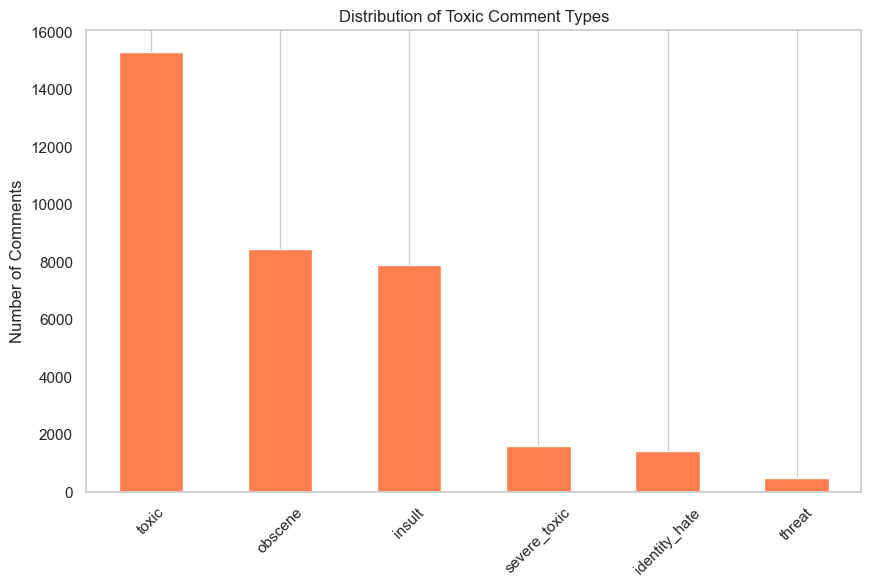

C:\Users\racmi\AppData\Local\Temp\ipykernel_1736\3282484739.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='n_labels', data=train, palette="Set2")


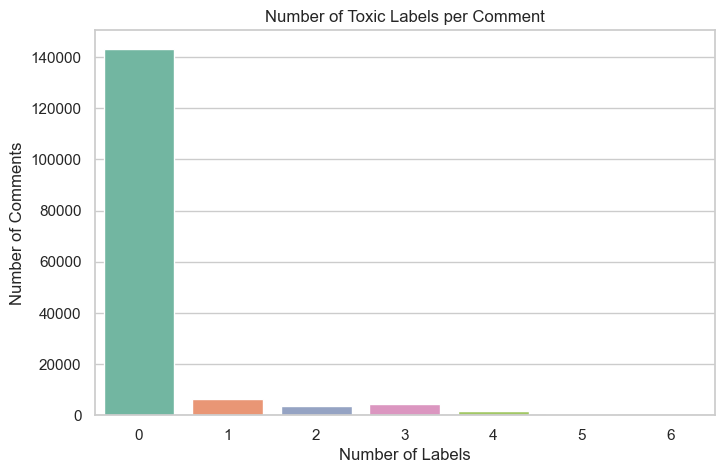

9865 comments (6.18%) have multiple toxicity labels.

Average word count by toxicity type:
 - toxic          : 51.29 words
 - severe_toxic   : 75.62 words
 - obscene        : 49.56 words
 - threat         : 55.17 words
 - insult         : 48.27 words
 - identity_hate  : 52.01 words


C:\Users\racmi\AppData\Local\Temp\ipykernel_1736\3282484739.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted, x="toxic_type", y="word_count", palette="pastel")


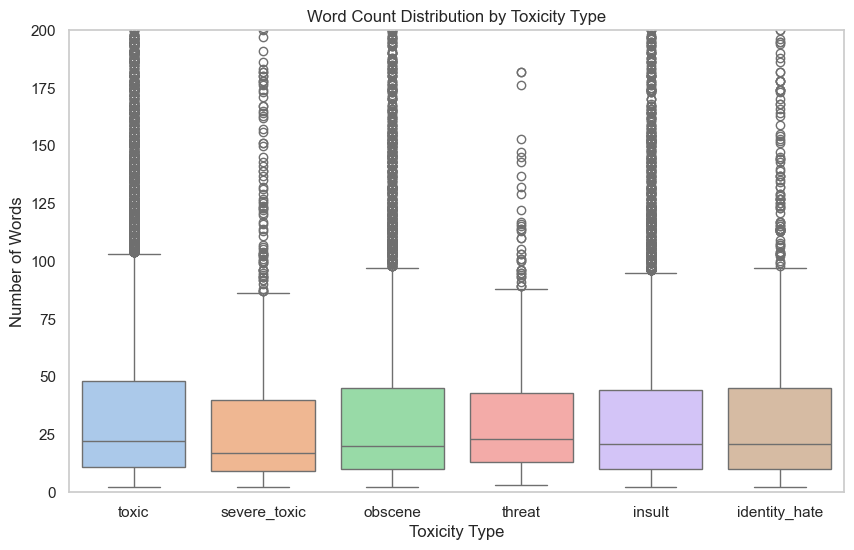

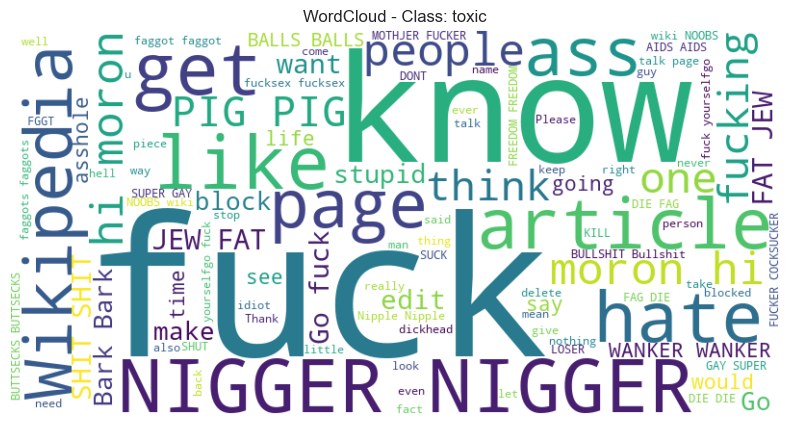

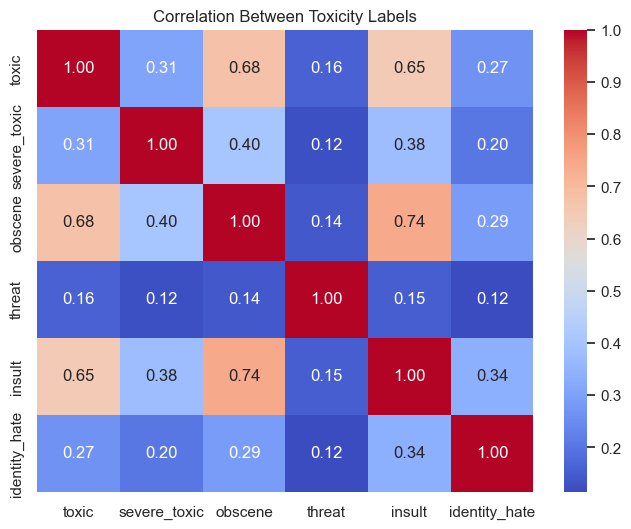

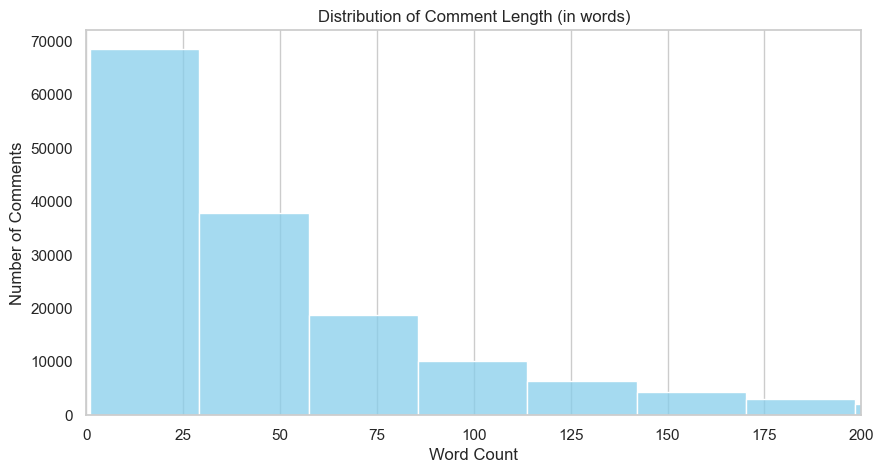

C:\Users\racmi\AppData\Local\Temp\ipykernel_1736\3282484739.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette="viridis")


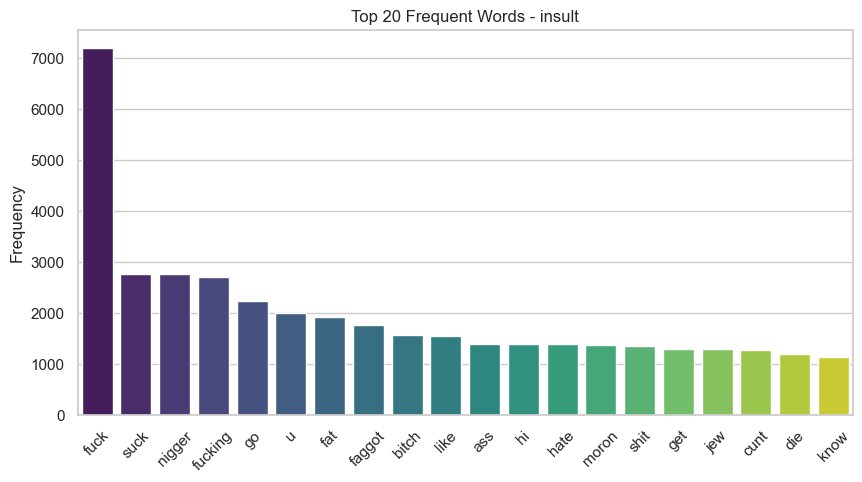

C:\Users\racmi\AppData\Local\Temp\ipykernel_1736\3282484739.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=terms, y=scores, palette="magma")


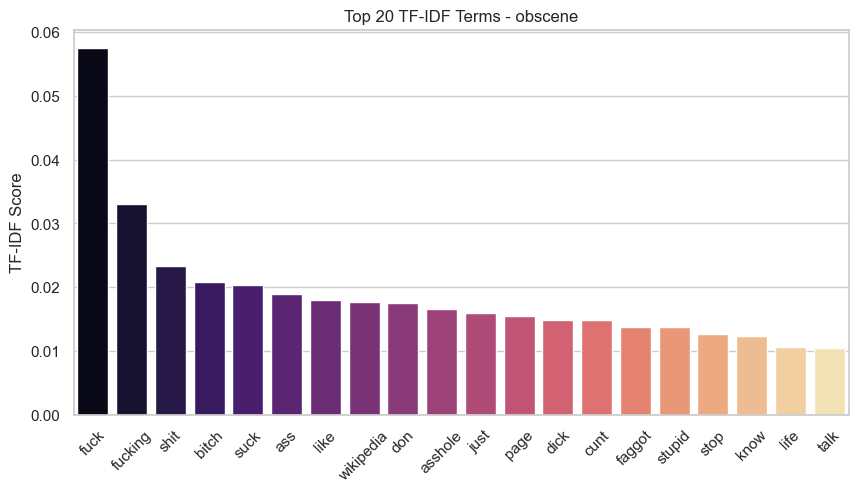

In [2]:
# Chapter 2 – Exploratory Data Analysis (EDA)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK stopwords
nltk.download('stopwords')

# Use a tokenizer that doesn't require punkt (avoids download issues)
tokenizer = TreebankWordTokenizer()

# Set global plot style
sns.set(style="whitegrid")

# Define multilabel columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
stop_words = set(stopwords.words("english"))

# 2.1 – Distribution of Toxic Comment Types
plt.figure(figsize=(10, 6))
train[label_cols].sum().sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title("Distribution of Toxic Comment Types")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 2.2 – Number of Toxic Labels per Comment
train['n_labels'] = train[label_cols].sum(axis=1)
plt.figure(figsize=(8, 5))
sns.countplot(x='n_labels', data=train, palette="Set2")
plt.title("Number of Toxic Labels per Comment")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Comments")
plt.show()

multi = (train['n_labels'] > 1).sum()
print(f"{multi} comments ({multi / len(train) * 100:.2f}%) have multiple toxicity labels.")

# 2.3 – Word Count per Comment and by Label
train['word_count'] = train['comment_text'].apply(lambda x: len(str(x).split()))
print("\nAverage word count by toxicity type:")
for label in label_cols:
    avg = train[train[label] == 1]['word_count'].mean()
    print(f" - {label:<15}: {avg:.2f} words")

# 2.4 – Boxplot of Word Count by Toxicity Type
melted = pd.melt(
    train,
    id_vars=['word_count'],
    value_vars=label_cols,
    var_name='toxic_type',
    value_name='is_present'
)
melted = melted[melted['is_present'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x="toxic_type", y="word_count", palette="pastel")
plt.title("Word Count Distribution by Toxicity Type")
plt.xlabel("Toxicity Type")
plt.ylabel("Number of Words")
plt.ylim(0, 200)
plt.grid(axis='y')
plt.show()

# 2.5 – WordCloud for Each Toxicity Class
def generate_wordcloud(label):
    text = " ".join(train[train[label] == 1]['comment_text'].astype(str))
    wordcloud = WordCloud(
        stopwords=stop_words,
        background_color='white',
        max_words=100,
        width=800,
        height=400
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - Class: {label}")
    plt.show()

# Example WordCloud for 'toxic' class
generate_wordcloud("toxic")

# 2.6 – Correlation Matrix Between Labels
plt.figure(figsize=(8, 6))
corr = train[label_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Toxicity Labels")
plt.show()

# 2.7 – Histogram of Comment Length (in Words)
plt.figure(figsize=(10, 5))
sns.histplot(train['word_count'], bins=50, kde=False, color='skyblue')
plt.title("Distribution of Comment Length (in words)")
plt.xlabel("Word Count")
plt.ylabel("Number of Comments")
plt.xlim(0, 200)
plt.grid(axis='y')
plt.show()

# 2.8 – Most Frequent Words for a Given Label (Term Frequency)
def top_words_by_label(label, n=20):
    texts = train[train[label] == 1]["comment_text"].astype(str)
    all_words = " ".join(texts).lower()
    tokens = [
        w for w in tokenizer.tokenize(all_words)
        if w.isalpha() and w not in stop_words
    ]
    counter = Counter(tokens).most_common(n)
    words, freqs = zip(*counter)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(freqs), palette="viridis")
    plt.title(f"Top {n} Frequent Words - {label}")
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.show()

# Example: frequent words for the 'insult' label
top_words_by_label("insult")

# 2.9 – Top TF-IDF Terms per Label
def top_tfidf_terms_per_label(label, n=20):
    texts = train[['comment_text', label]].copy()
    texts = texts[texts[label] == 1]['comment_text'].astype(str)

    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    X_tfidf = tfidf.fit_transform(texts)
    means = X_tfidf.mean(axis=0).A1
    top_indices = means.argsort()[-n:][::-1]
    terms = tfidf.get_feature_names_out()[top_indices]
    scores = means[top_indices]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=terms, y=scores, palette="magma")
    plt.title(f"Top {n} TF-IDF Terms - {label}")
    plt.xticks(rotation=45)
    plt.ylabel("TF-IDF Score")
    plt.show()

# Example: TF-IDF for the 'obscene' label
top_tfidf_terms_per_label("obscene")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\racmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original comment:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Cleaned comment:
explan edit made usernam hardcor metallica fan revert werent vandal closur ga vote new york doll fac pleas dont remov templat talk page sinc retir

Average word count – Original: 67.27352714465661
Average word count – Cleaned: 30.017120905427678
Average comment length reduction: 55.38%


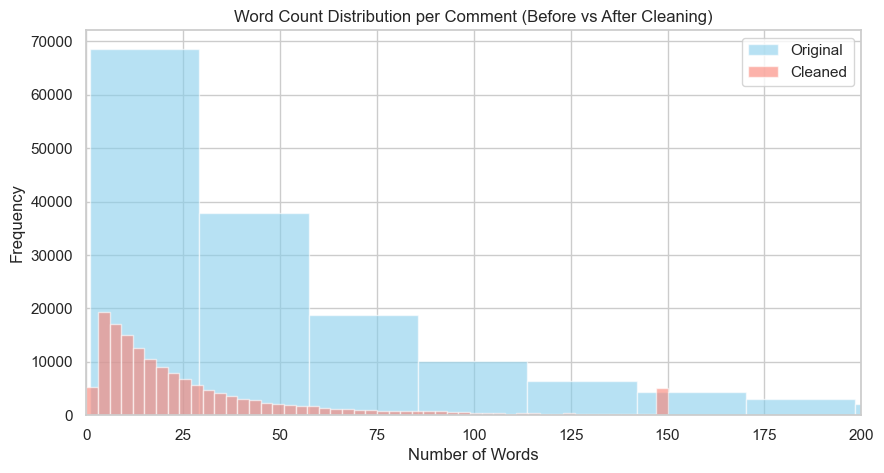

🔹 Original:
Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?

🔧 Cleaned:
geez forget weve alreadi discuss marx anarchist want use state mold socialist man ergo statist opposit anarchist know guy say get old teeth fall hell quit eat meat would call vegetarian
🔹 Original:
Carioca RFA 

Thanks for your support on my request for adminship.

The final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!

🔧 Cleaned:
carioca rfa thank support request adminship final outcom administr comment concern action administr pleas let know thank
🔹 Original:
"

 Birthday 

No worries, It's what I do ;)Enjoy ur day|talk|e "

🔧 Clean

In [3]:
# Chapter 3 – Data Preprocessing

import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

# Download stopwords if not already present
nltk.download('stopwords')

# Initialize NLP tools
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = TreebankWordTokenizer()

# Custom list of informal expressions, interjections, and slang
custom_stopwords = set([
    'gee', 'omg', 'wtf', 'lol', 'rofl', 'lmao', 'idk', 'idc', 'hahaha', 'haha',
    'yeah', 'uhh', 'umm', 'damn', 'bro', 'yo', 'dude', 'nah', 'ayy', 'tsk', 'awww'
])

# Offensive word roots for regex detection (creative variants)
offensive_roots = [
    'fuck', 'shit', 'bitch', 'nigger', 'fag', 'asshole', 'cunt', 'dick', 'bastard'
]

# Create flexible regex patterns to match variations of toxic words
def create_offensive_pattern(word):
    chars = list(word)
    pattern = r'\W*'.join(chars)  # Example: f\W*u\W*c\W*k
    return rf'\b{pattern}\b'

# Compile all regex patterns into one
offensive_patterns = [create_offensive_pattern(word) for word in offensive_roots]
compiled_offensive_regex = re.compile('|'.join(offensive_patterns), re.IGNORECASE)

# Robust text cleaning function
def clean_text(text, max_words=150):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove excessive spaces and line breaks
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # 3b. Replace creative swear word variants with placeholder
    text = compiled_offensive_regex.sub("toxicword", text)

    # 4. Remove emojis and non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # 5. Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # 6. Tokenization
    tokens = tokenizer.tokenize(text)

    # 7. Remove stopwords and apply stemming
    clean_tokens = []
    for w in tokens:
        if w not in stop_words and w not in custom_stopwords and len(w) > 2 and w.isalpha():
            try:
                clean_tokens.append(stemmer.stem(w))
            except RecursionError:
                continue
    tokens = clean_tokens

    # 8. Limit to maximum word count
    tokens = tokens[:max_words]

    return ' '.join(tokens)

# Apply text cleaning to a DataFrame
def apply_cleaning_to_dataframe(df, text_column='comment_text', new_column='clean_text'):
    df[new_column] = df[text_column].apply(clean_text)
    return df

# Apply to training and testing datasets
train = apply_cleaning_to_dataframe(train)
test = apply_cleaning_to_dataframe(test)

# Show an example of original and cleaned comment
print("Original comment:")
print(train['comment_text'].iloc[0])
print("\nCleaned comment:")
print(train['clean_text'].iloc[0])

# Save cleaned versions to CSV
train.to_csv("train_clean.csv", index=False)
test.to_csv("test_clean.csv", index=False)

# Word count comparison before and after cleaning
train['original_word_count'] = train['comment_text'].apply(lambda x: len(str(x).split()))
train['clean_word_count'] = train['clean_text'].apply(lambda x: len(str(x).split()))

print("\nAverage word count – Original:", train['original_word_count'].mean())
print("Average word count – Cleaned:", train['clean_word_count'].mean())

reduction = 100 * (1 - (train['clean_word_count'].mean() / train['original_word_count'].mean()))
print(f"Average comment length reduction: {reduction:.2f}%")

# Visualization: word count distribution
plt.figure(figsize=(10, 5))
plt.hist(train['original_word_count'], bins=50, alpha=0.6, label='Original', color='skyblue')
plt.hist(train['clean_word_count'], bins=50, alpha=0.6, label='Cleaned', color='salmon')
plt.legend()
plt.title("Word Count Distribution per Comment (Before vs After Cleaning)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xlim(0, 200)
plt.show()

# Display 5 random cleaned examples
samples = train[['comment_text', 'clean_text']].sample(5, random_state=42)
for _, row in samples.iterrows():
    print("=" * 80)
    print("🔹 Original:")
    print(row['comment_text'])
    print("\n🔧 Cleaned:")
    print(row['clean_text'])
    print("=" * 80)


In [4]:
# Chapter 4 – Feature Extraction with TF-IDF

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib

# 1. Load preprocessed training and test datasets
train = pd.read_csv("train_clean.csv")
test = pd.read_csv("test_clean.csv")

# 2. Define input texts and multilabel targets
X_text = train["clean_text"].fillna("")
y = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# 3. Configure TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,         # Limit to 10,000 most important features
    ngram_range=(1, 2),         # Use unigrams and bigrams
    stop_words="english",       # Remove built-in English stopwords
    sublinear_tf=True           # Apply sublinear TF scaling (log(1 + tf))
)

# 4. Fit the vectorizer on training text and transform both train/test sets
X_tfidf = vectorizer.fit_transform(X_text)
X_test_tfidf = vectorizer.transform(test["clean_text"].fillna(""))

# 5. Split TF-IDF features and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42
)

# 6. Display shape and sample features for sanity check
print("TF-IDF shape (train):", X_train.shape)
print("TF-IDF shape (val):", X_val.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)
print("Example feature names:", vectorizer.get_feature_names_out()[:20])

# 7. Save vectorized data and TF-IDF model
joblib.dump((X_train, y_train), "tfidf_train.pkl")
joblib.dump((X_val, y_val), "tfidf_val.pkl")
joblib.dump((X_test_tfidf, test[["id"]]), "tfidf_test.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("✅ TF-IDF feature extraction complete and saved.")


TF-IDF shape (train): (127656, 10000)
TF-IDF shape (val): (31915, 10000)
TF-IDF shape (test): (153164, 10000)
Example feature names: ['aaron' 'abandon' 'abbrevi' 'abc' 'abid' 'abil' 'abl' 'abl edit'
 'abl make' 'abolish' 'aborigin' 'abort' 'abraham' 'abroad' 'absenc'
 'absent' 'absolut' 'absolut noth' 'abstract' 'absurd']
✅ TF-IDF feature extraction complete and saved.



Training: Logistic Regression
→ Evaluation Metrics:
               precision    recall  f1-score   support

        toxic       0.90      0.63      0.74      3056
 severe_toxic       0.57      0.25      0.35       321
      obscene       0.89      0.64      0.75      1715
       threat       0.62      0.14      0.22        74
       insult       0.81      0.52      0.63      1614
identity_hate       0.71      0.12      0.21       294

    micro avg       0.87      0.56      0.68      7074
    macro avg       0.75      0.38      0.48      7074
 weighted avg       0.85      0.56      0.67      7074
  samples avg       0.06      0.05      0.05      7074



C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


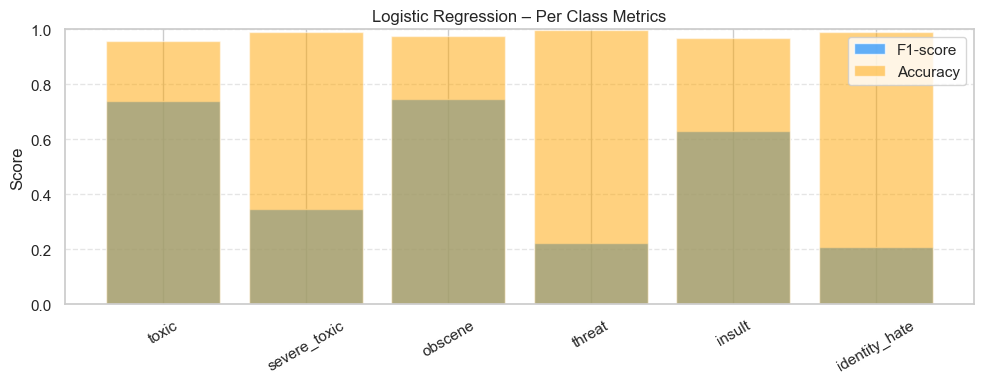

✅ Saved: model_logistic_regression.pkl

Training: SGDClassifier (Linear SVM)
→ Evaluation Metrics:
               precision    recall  f1-score   support

        toxic       0.95      0.51      0.66      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.89      0.63      0.74      1715
       threat       0.00      0.00      0.00        74
       insult       0.79      0.46      0.59      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.89      0.48      0.62      7074
    macro avg       0.44      0.27      0.33      7074
 weighted avg       0.81      0.48      0.60      7074
  samples avg       0.05      0.04      0.04      7074



C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklea

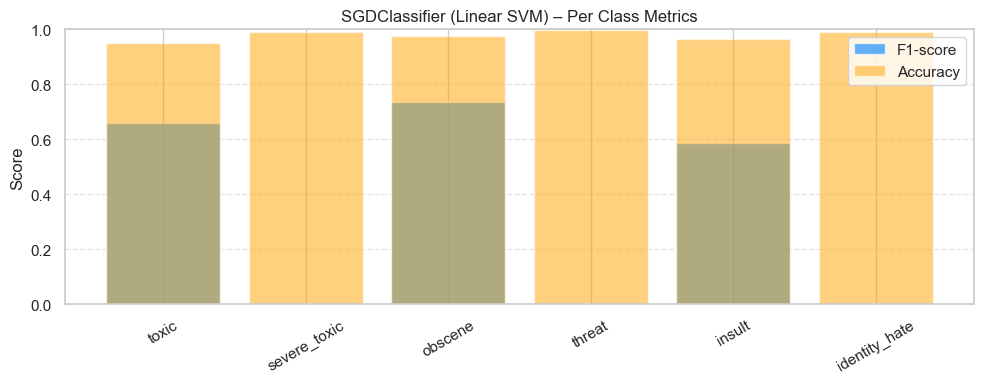

✅ Saved: model_sgdclassifier_(linear_svm).pkl

Training: Naive Bayes
→ Evaluation Metrics:
               precision    recall  f1-score   support

        toxic       0.92      0.51      0.66      3056
 severe_toxic       0.58      0.20      0.29       321
      obscene       0.90      0.51      0.65      1715
       threat       0.00      0.00      0.00        74
       insult       0.80      0.43      0.56      1614
identity_hate       0.42      0.06      0.11       294

    micro avg       0.87      0.45      0.59      7074
    macro avg       0.60      0.28      0.38      7074
 weighted avg       0.84      0.45      0.58      7074
  samples avg       0.05      0.04      0.04      7074



C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


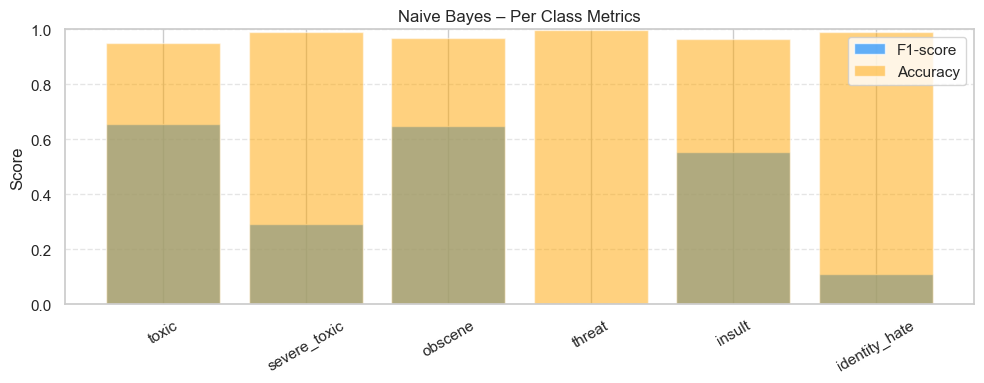

✅ Saved: model_naive_bayes.pkl


<Figure size 1000x600 with 0 Axes>

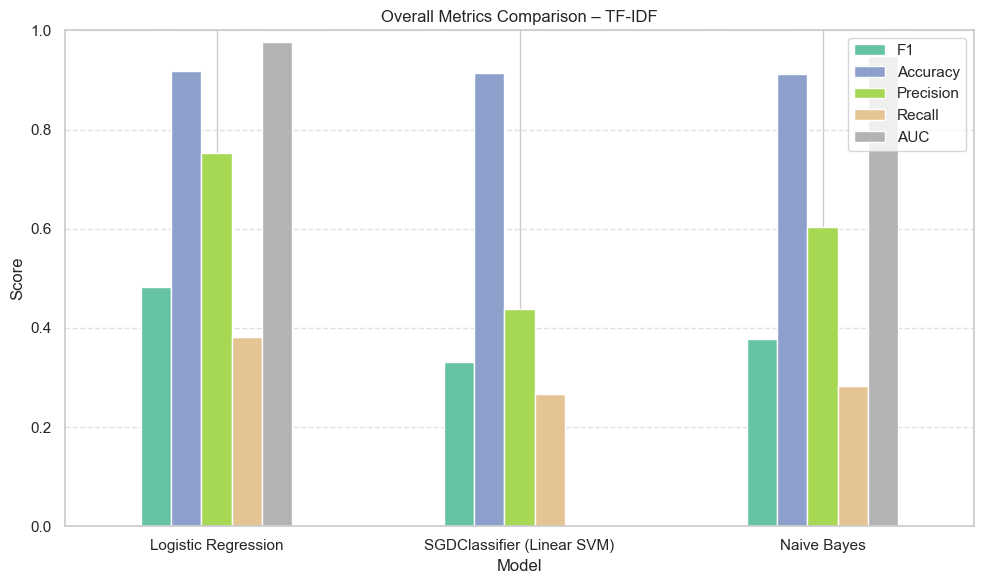

In [5]:
# Chapter 5 – Model Training and Evaluation with TF-IDF

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.preprocessing import MinMaxScaler

# 1. Load TF-IDF features and multilabel targets
X_train, y_train = joblib.load("tfidf_train.pkl")
X_val, y_val = joblib.load("tfidf_val.pkl")

# 2. Load TF-IDF vectorizer to extract interpretable feature names
vectorizer = joblib.load("tfidf_vectorizer.pkl")
feature_names = vectorizer.get_feature_names_out()

# 3. Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs", n_jobs=-1),
    "SGDClassifier (Linear SVM)": SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB()
}

summary = []  # Store global performance metrics

# 4. Train and evaluate each model
for name, base_model in models.items():
    print(f"\n{'=' * 30}\nTraining: {name}\n{'=' * 30}")

    model = MultiOutputClassifier(base_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Normalize predicted probabilities for AUC (only for models that support predict_proba)
    if hasattr(model, "predict_proba"):
        try:
            y_proba = model.predict_proba(X_val)
            if isinstance(y_proba, list):
                y_proba = np.array([p[:, 1] for p in y_proba]).T
            scaler = MinMaxScaler()
            y_proba = scaler.fit_transform(y_proba)
            auc = roc_auc_score(y_val, y_proba, average="macro")
        except Exception:
            auc = 0.0
    else:
        auc = 0.0

    # Print classification report
    print("→ Evaluation Metrics:")
    print(classification_report(y_val, y_pred, target_names=y_train.columns))

    # Compute per-label F1-score and Accuracy
    f1_scores = f1_score(y_val, y_pred, average=None)
    acc_scores = [
        accuracy_score(y_val.iloc[:, i], y_pred[:, i])
        for i in range(y_val.shape[1])
    ]

    macro_f1 = f1_score(y_val, y_pred, average="macro")
    macro_acc = accuracy_score(y_val, y_pred)
    macro_precision = precision_score(y_val, y_pred, average="macro", zero_division=0)
    macro_recall = recall_score(y_val, y_pred, average="macro", zero_division=0)

    summary.append({
        "Model": name,
        "F1": macro_f1,
        "Accuracy": macro_acc,
        "Precision": macro_precision,
        "Recall": macro_recall,
        "AUC": auc
    })

    # Bar chart per class
    plt.figure(figsize=(10, 4))
    plt.bar(y_train.columns, f1_scores, color="dodgerblue", alpha=0.7, label="F1-score")
    plt.bar(y_train.columns, acc_scores, color="orange", alpha=0.5, label="Accuracy")
    plt.title(f"{name} – Per Class Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Interpretability for linear models
    if hasattr(base_model, "coef_"):
        for i, label in enumerate(y_train.columns):
            print(f"\nClass: {label}")
            top_positive = np.argsort(base_model.coef_[i])[-10:][::-1]
            top_negative = np.argsort(base_model.coef_[i])[:10]
            print("Top Positive Words:", feature_names[top_positive])
            print("Top Negative Words:", feature_names[top_negative])

    # Save model
    filename = f"model_{name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved: {filename}")

# 5. Summary: Compare model performance
summary_df = pd.DataFrame(summary)

# Plot global comparison
plt.figure(figsize=(10, 6))
summary_df.set_index("Model")[["F1", "Accuracy", "Precision", "Recall", "AUC"]].plot(
    kind="bar", figsize=(10, 6), colormap="Set2"
)
plt.title("Overall Metrics Comparison – TF-IDF")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [6]:
# Chapter 6 – Feature Extraction with Word Embeddings (spaCy)

import numpy as np
import pandas as pd
import spacy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load spaCy model with pre-trained word vectors
print("🔄 Loading spaCy model with pre-trained vectors...")
nlp = spacy.load("en_core_web_md")

# 2. Load cleaned dataset
train_df = pd.read_csv("train_clean.csv")
X_text = train_df["clean_text"].fillna("").tolist()
y = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

# 3. Function to extract sentence-level embeddings using spaCy
def get_spacy_embeddings(texts, nlp_model):
    """
    Generate sentence embeddings by averaging token vectors from spaCy.
    If no vector is available, return a zero vector of the same dimension.
    """
    print("🧠 Generating spaCy embeddings...")
    embeddings = []
    for doc in tqdm(nlp_model.pipe(texts, batch_size=500), total=len(texts), desc="spaCy Embedding"):
        if doc.has_vector:
            embeddings.append(doc.vector)
        else:
            embeddings.append(np.zeros(nlp_model.vocab.vectors_length))
    return np.array(embeddings)

# Apply the embedding extraction
X_embeddings = get_spacy_embeddings(X_text, nlp)

# 4. Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42
)

# 5. Standardize the embeddings using z-score normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 6. Save all generated arrays to disk
np.save("X_emb_train.npy", X_train)
np.save("X_emb_val.npy", X_val)
np.save("y_emb_train.npy", y_train)
np.save("y_emb_val.npy", y_val)
np.save("X_emb_train_scaled.npy", X_train_scaled)
np.save("X_emb_val_scaled.npy", X_val_scaled)

# 7. Final summary
print("\n✅ Embedding extraction complete.")
print(f"Training set shape: {X_train.shape} | Validation set shape: {X_val.shape}")


🔄 Loading spaCy model with pre-trained vectors...
🧠 Generating spaCy embeddings...


spaCy Embedding: 100%|████████████████████████████████████████████████████████| 159571/159571 [12:34<00:00, 211.38it/s]



✅ Embedding extraction complete.
Training set shape: (127656, 300) | Validation set shape: (31915, 300)



Training: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.38      0.50      3056
           1       0.33      0.07      0.11       321
           2       0.68      0.27      0.39      1715
           3       0.38      0.15      0.21        74
           4       0.64      0.26      0.37      1614
           5       0.32      0.06      0.11       294

   micro avg       0.69      0.30      0.41      7074
   macro avg       0.52      0.20      0.28      7074
weighted avg       0.66      0.30      0.41      7074
 samples avg       0.03      0.03      0.03      7074


Training: Linear SVM (SGDClassifier)
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.32      0.45      3056
           1       0.26      0.11      0.16       321
           2       0.62      0.30      0.40      1715
           3       0.24      0.09      0.14        74
           4     

C:\Users\racmi\AppData\Local\Temp\ipykernel_1736\3265855350.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1", data=results_df, palette="magma")


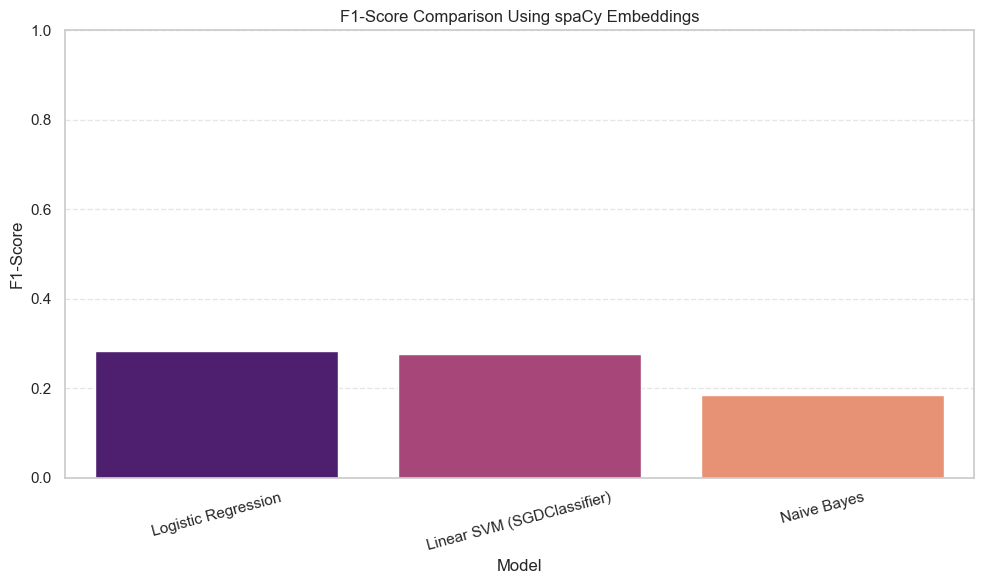


✅ Best spaCy-based model: Logistic Regression
📦 Model saved to: best_model_embeddings_logistic_regression.pkl


In [7]:
# Chapter 7 – Modeling with spaCy Embeddings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.preprocessing import MinMaxScaler

# 1. Load scaled word embeddings and target labels
X_train = np.load("X_emb_train_scaled.npy")
X_val = np.load("X_emb_val_scaled.npy")
y_train = np.load("y_emb_train.npy")
y_val = np.load("y_emb_val.npy")

# 2. Define models to evaluate with multilabel support
models = {
    "Logistic Regression": MultiOutputClassifier(
        LogisticRegression(max_iter=1000, solver="lbfgs", n_jobs=-1, random_state=42)
    ),
    "Linear SVM (SGDClassifier)": MultiOutputClassifier(
        SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, random_state=42)
    ),
    "Naive Bayes": MultiOutputClassifier(
        GaussianNB()
    )
}

results = []  # Store overall model performance

# 3. Train and evaluate each model
for name, model in models.items():
    print(f"\n{'=' * 30}\nTraining: {name}\n{'=' * 30}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Compute metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)
    precision = precision_score(y_val, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_val, y_pred, average="macro", zero_division=0)

    # Compute AUC if model supports predict_proba
    try:
        y_proba = model.predict_proba(X_val)
        if isinstance(y_proba, list):
            y_proba = np.array([p[:, 1] for p in y_proba]).T
        scaler = MinMaxScaler()
        y_proba = scaler.fit_transform(y_proba)
        auc = roc_auc_score(y_val, y_proba, average="macro")
    except Exception:
        auc = 0.0

    # Print report
    print("Classification Report:")
    print(classification_report(y_val, y_pred, zero_division=0))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "AUC": auc
    })

# 4. Save and display summary metrics
results_df = pd.DataFrame(results)
print("\nSummary of Metrics:")
print(results_df)
results_df.to_csv("spaCy_model_metrics.csv", index=False)

# 5. Plot F1-score comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="F1", data=results_df, palette="magma")
plt.title("F1-Score Comparison Using spaCy Embeddings")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 6. Save the best-performing model
best_model_name = results_df.sort_values(by="F1", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]
best_model_path = f"best_model_embeddings_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model, best_model_path)

print(f"\n✅ Best spaCy-based model: {best_model_name}")
print(f"📦 Model saved to: {best_model_path}")



🚀 Starting RandomizedSearchCV...
Fitting 2 folds for each of 6 candidates, totalling 12 fits

⏱️ Tuning took 0.57 minutes

✅ Best Hyperparameters Found:
{'estimator__C': 7.742636826811277}

📊 Final Classification Report:
               precision    recall  f1-score   support

        toxic       0.87      0.69      0.77      3056
 severe_toxic       0.47      0.27      0.35       321
      obscene       0.87      0.68      0.77      1715
       threat       0.52      0.22      0.30        74
       insult       0.78      0.56      0.65      1614
identity_hate       0.61      0.24      0.35       294

    micro avg       0.83      0.62      0.71      7074
    macro avg       0.69      0.44      0.53      7074
 weighted avg       0.82      0.62      0.70      7074
  samples avg       0.06      0.06      0.06      7074



C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\racmi\AppData\Local\Temp\ipykern

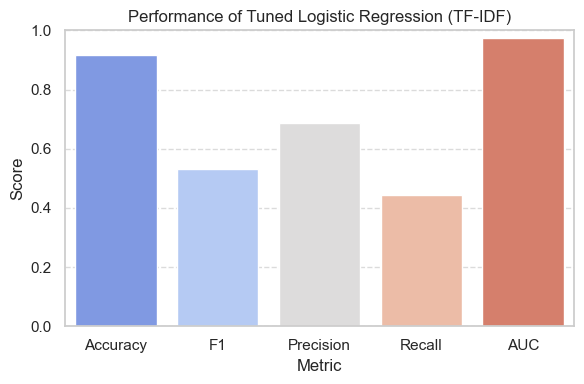

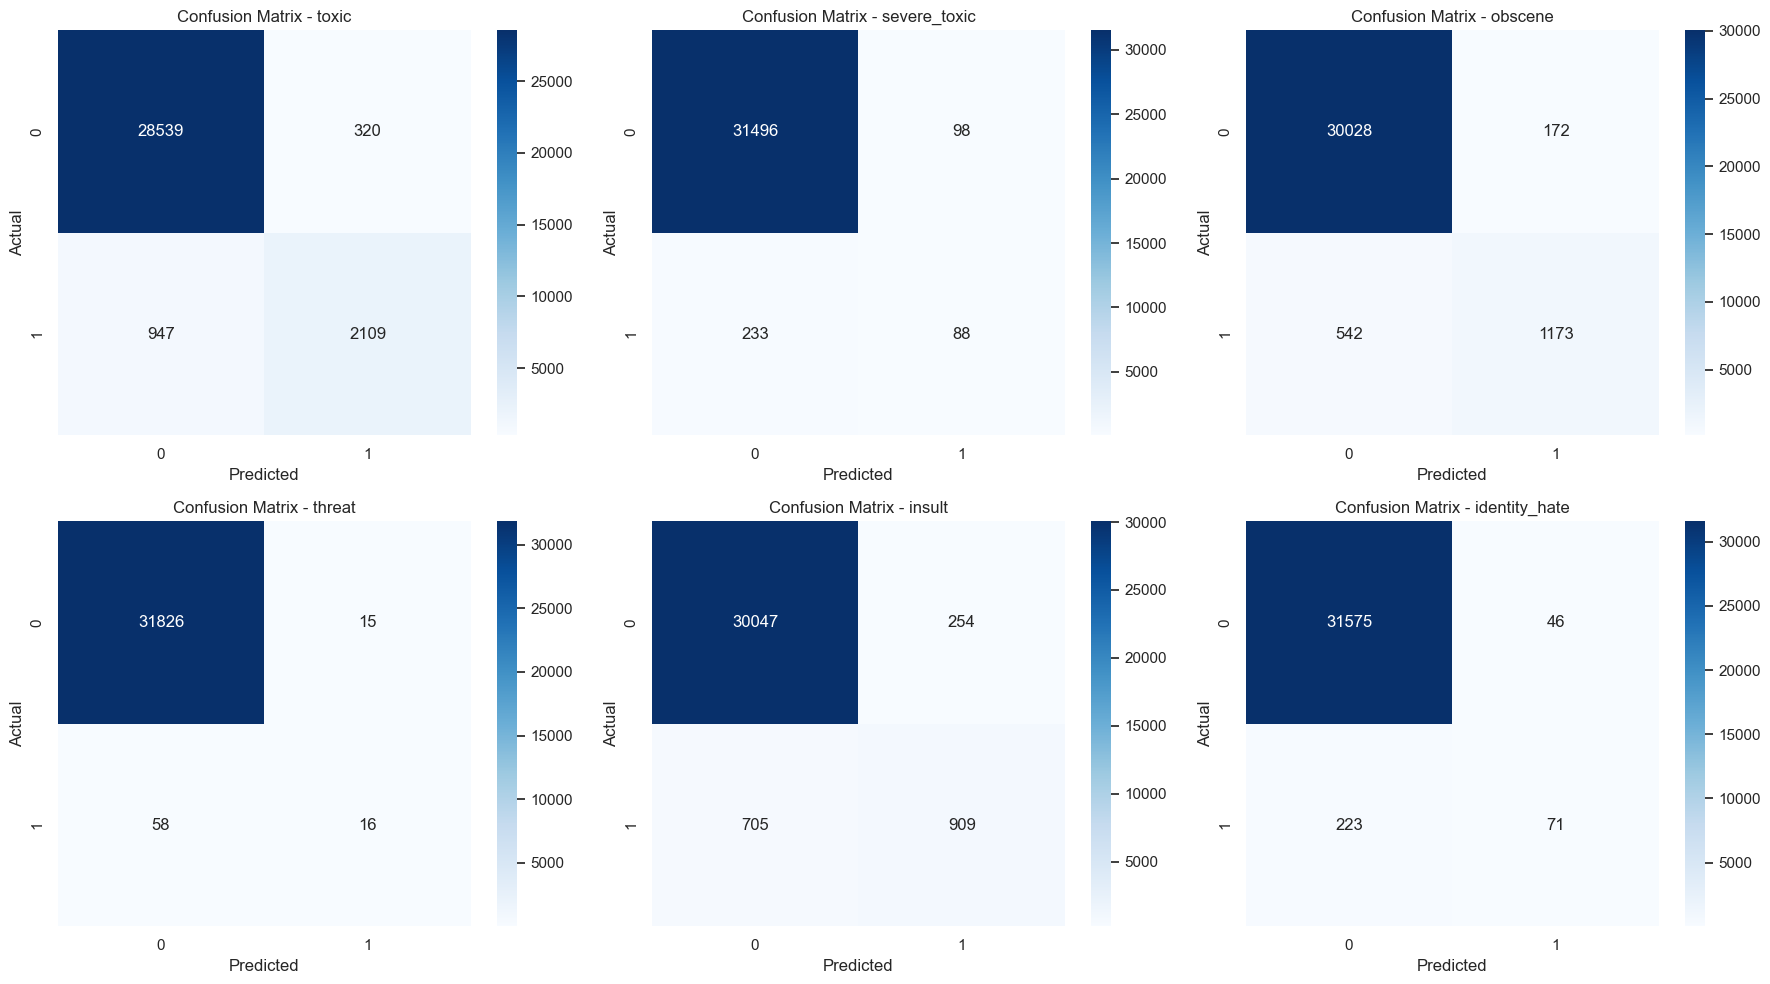

In [8]:
# Chapter 8 – Hyperparameter Tuning with RandomizedSearchCV (Optimized TF-IDF)

import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

# 1. Load TF-IDF features and labels
X_train, y_train = joblib.load("tfidf_train.pkl")
X_val, y_val = joblib.load("tfidf_val.pkl")

# 2. Define base model
base_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    penalty="l2",
    n_jobs=-1
)

# 3. Define parameter grid
param_dist = {
    "estimator__C": np.logspace(-3, 2, 10)
}

# 4. Wrap for multilabel
multi_model = MultiOutputClassifier(base_model)

# 5. Setup search
random_search = RandomizedSearchCV(
    estimator=multi_model,
    param_distributions=param_dist,
    n_iter=6,
    scoring="f1_macro",
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 6. Run search with timing
print("\n🚀 Starting RandomizedSearchCV...")
start = time.time()
random_search.fit(X_train, y_train)
print(f"\n⏱️ Tuning took {(time.time() - start) / 60:.2f} minutes")

# 7. Evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="macro")
precision = precision_score(y_val, y_pred, average="macro")
recall = recall_score(y_val, y_pred, average="macro")

# 8. AUC Score
try:
    y_proba = best_model.predict_proba(X_val)
    if isinstance(y_proba, list):
        y_proba = np.array([p[:, 1] for p in y_proba]).T
    auc = roc_auc_score(y_val, y_proba, average="macro")
except:
    auc = 0.0

print("\n✅ Best Hyperparameters Found:")
print(random_search.best_params_)

print("\n📊 Final Classification Report:")
print(classification_report(y_val, y_pred, target_names=y_train.columns))

# 9. Save model
joblib.dump(best_model, "best_model_tuned_logistic_regression.pkl")

# 10. Plot metrics
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1", "Precision", "Recall", "AUC"],
    "Score": [accuracy, f1, precision, recall, auc]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=metrics_df, x="Metric", y="Score", palette="coolwarm")
plt.title("Performance of Tuned Logistic Regression (TF-IDF)")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 11. Confusion Matrices (per label)
labels = list(y_train.columns)
y_val_df = pd.DataFrame(y_val, columns=labels)
y_pred_df = pd.DataFrame(y_pred, columns=labels)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, label in enumerate(labels):
    cm = confusion_matrix(y_val_df[label], y_pred_df[label])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {label}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [9]:
## Chapter 9 – Kaggle Submission File Generation

import pandas as pd
import numpy as np
import joblib

# 1. Load original test dataset with comment IDs
test_df = pd.read_csv("test.csv")
X_test_text = test_df["comment_text"].fillna("")

# 2. Load pre-cleaned version of the test set
test_clean = pd.read_csv("test_clean.csv")
X_clean_text = test_clean["clean_text"].fillna("")

# 3. Load the saved TF-IDF vectorizer and transform the cleaned test data
vectorizer = joblib.load("tfidf_vectorizer.pkl")
X_test_tfidf = vectorizer.transform(X_clean_text)

# 4. Load the tuned Logistic Regression model
best_model = joblib.load("best_model_tuned_logistic_regression.pkl")

# 5. Predict class probabilities for each label
y_pred_proba = best_model.predict_proba(X_test_tfidf)

# 6. Handle MultiOutputClassifier's output format
# If it's a list, convert to a 2D numpy array with one column per label
if isinstance(y_pred_proba, list):
    y_pred_proba = np.array([p[:, 1] for p in y_pred_proba]).T

# 7. Build submission DataFrame with correct column names
submission = pd.DataFrame(
    y_pred_proba,
    columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
)

# 8. Add comment ID column at the beginning of the DataFrame
submission.insert(0, "id", test_df["id"])

# 9. Export the submission file in the required format
submission.to_csv("submission.csv", index=False)

print("✅ Submission file 'submission.csv' generated successfully.")


✅ Submission file 'submission.csv' generated successfully.
